In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("maedemaftouni/covid19-ct-scan-lesion-segmentation-dataset")

print("Path to dataset files:", path)

# Define dataset paths
frames_dir = path + "/frames"
masks_dir = path + "/masks"
text_dir = "/kaggle/input/text-file"
print("Frames directory:", frames_dir)
print("Masks directory:", masks_dir)
#/kaggle/input/text-file

Path to dataset files: /kaggle/input/covid19-ct-scan-lesion-segmentation-dataset
Frames directory: /kaggle/input/covid19-ct-scan-lesion-segmentation-dataset/frames
Masks directory: /kaggle/input/covid19-ct-scan-lesion-segmentation-dataset/masks


In [3]:
!pip install openpyxl


In [4]:
import os
import pandas as pd

# Directories containing the Excel files
dir1 = "/kaggle/input/text-file-1/"
dir2 = "/kaggle/input/text-data-2/"
dir3 = "/kaggle/input/text-data-3/"

# List of directories to combine
dirs = [dir1, dir2, dir3]

# Initialize an empty DataFrame to hold combined data
combined_df = pd.DataFrame()

# Iterate through each directory and combine Excel files
for directory in dirs:
    for filename in os.listdir(directory):
        if filename.lower().endswith(".xlsx"):
            file_path = os.path.join(directory, filename)
            print(f"Reading: {file_path}")
            try:
                # Read the Excel file into a DataFrame
                df = pd.read_excel(file_path)
                # Append to the combined DataFrame
                combined_df = pd.concat([combined_df, df], ignore_index=True)
            except Exception as e:
                print(f"Error reading {file_path}: {e}")

# Define output path (write to /kaggle/working/ because input directories are read-only)
output_file_path = "/kaggle/working/combined_text.xlsx"

# Write the combined DataFrame to an Excel file
combined_df.to_excel(output_file_path, index=False)
print(f"Combined Excel file created at: {output_file_path}")


Reading: /kaggle/input/text-file-1/Train_text_MosMedData 1.xlsx
Reading: /kaggle/input/text-data-2/Val_text_MosMedData 1_2.xlsx
Reading: /kaggle/input/text-data-3/Test_text_MosMedData_3.xlsx
Combined Excel file created at: /kaggle/working/combined_text.xlsx


In [5]:
!ls -l /kaggle/working/
import pandas as pd

# Load the combined Excel file from /kaggle/working/
combined_file_path = "/kaggle/working/combined_text.xlsx"
df_combined = pd.read_excel(combined_file_path)

# Print the first 5 rows of the combined text dataset
print(df_combined.head(5))
print(df_combined.shape)


total 44
-rw-r--r-- 1 root root 43508 Mar 26 08:15 combined_text.xlsx
            Image                                               text
0    bjorke_1.png  Bilateral pulmonary infection, two infected ar...
1   bjorke_10.png  Bilateral pulmonary infection, two infected ar...
2  bjorke_100.png  Bilateral pulmonary infection, nine infected a...
3   bjorke_11.png  Bilateral pulmonary infection, nine infected a...
4   bjorke_12.png  Bilateral pulmonary infection, three infected ...
(2729, 2)


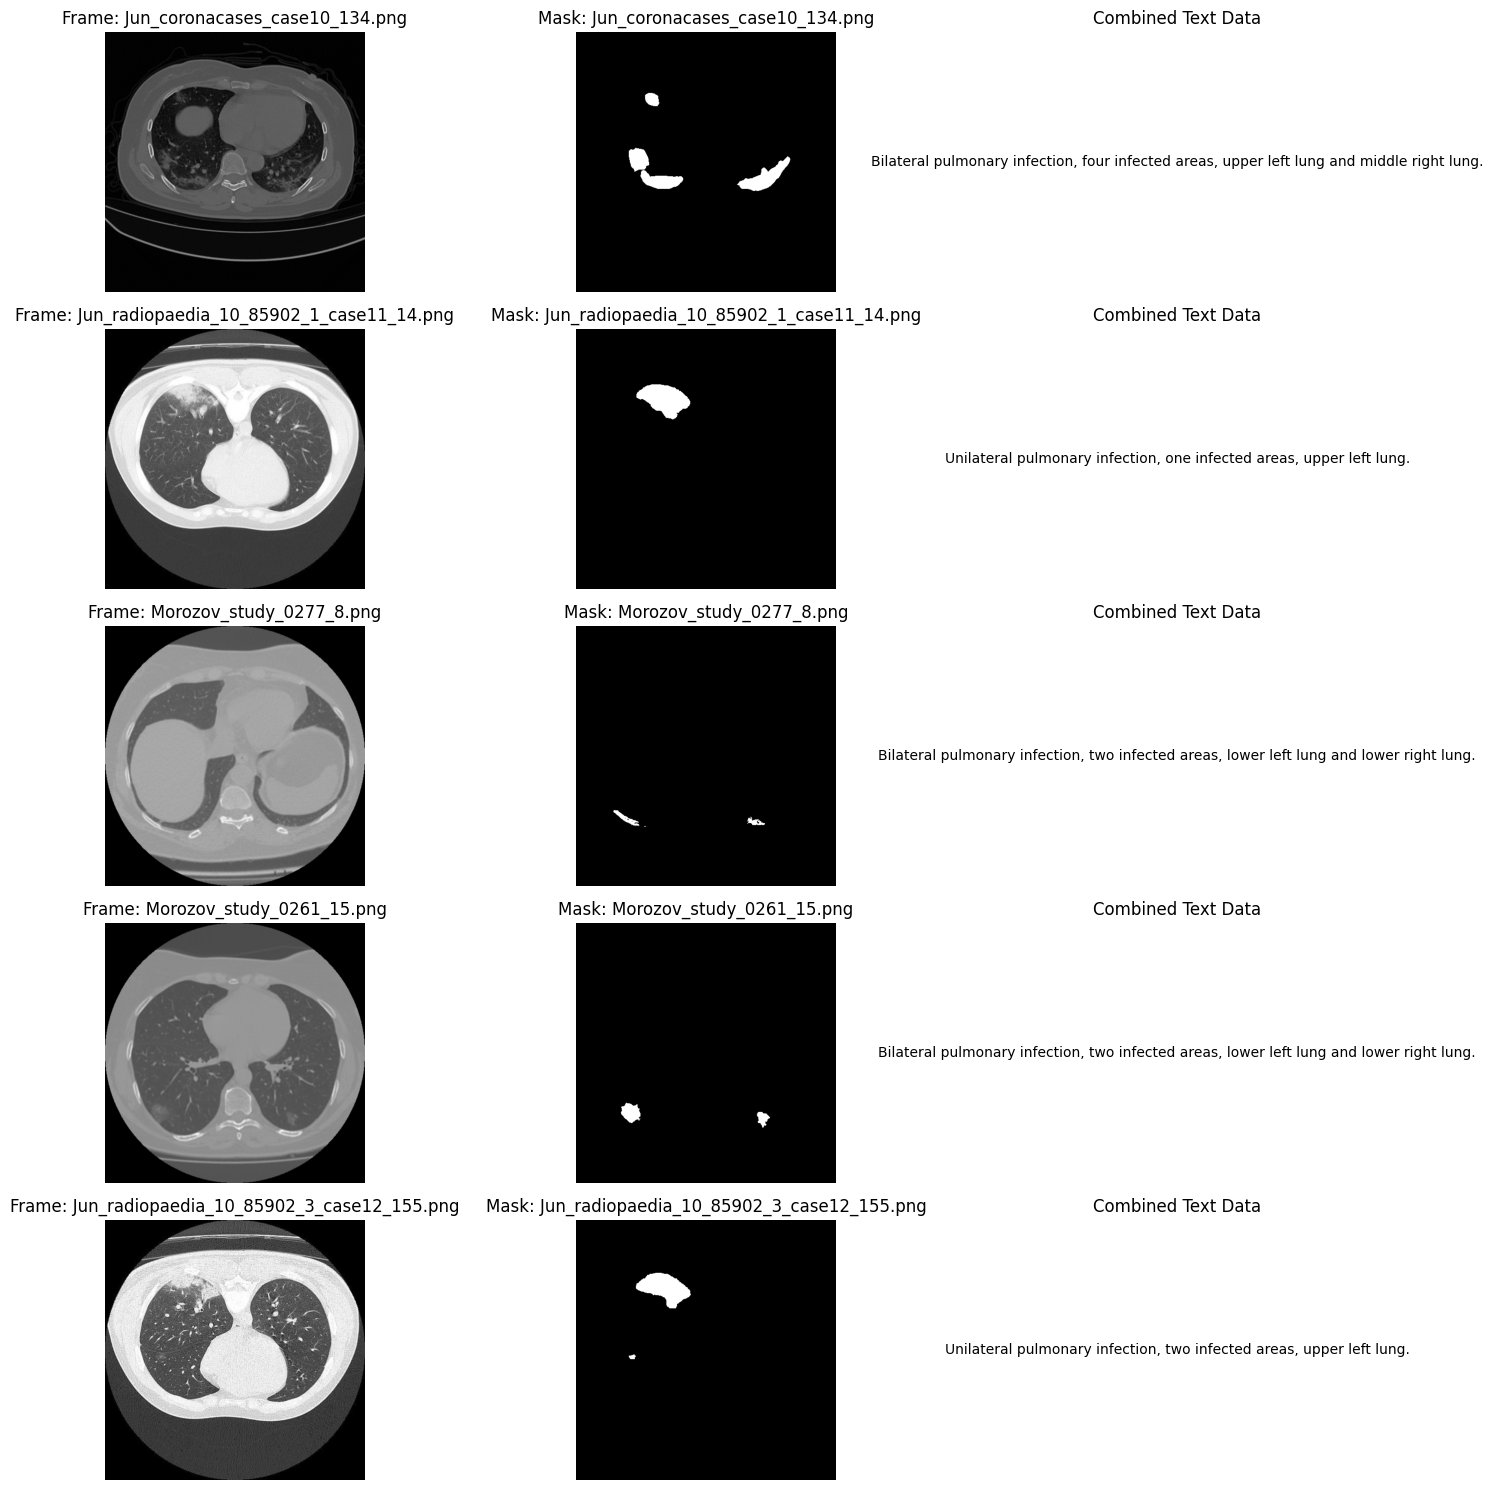

In [6]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd

# Define dataset paths for images and masks
frames_dir = "/kaggle/input/covid19-ct-scan-lesion-segmentation-dataset/frames"
masks_dir = "/kaggle/input/covid19-ct-scan-lesion-segmentation-dataset/masks"

# Path to the combined text file (Excel file with columns "Image" and "text")
combined_text_path = "/kaggle/working/combined_text.xlsx"

# Read the combined text file into a DataFrame
df_text = pd.read_excel(combined_text_path)

# Get a list of all frame files that have corresponding masks
frame_files = sorted([
    f for f in os.listdir(frames_dir)
    if f.lower().endswith(('.png', '.jpg', '.jpeg')) and os.path.exists(os.path.join(masks_dir, f))
])

if not frame_files:
    raise ValueError("No matching frame and mask files found.")

# Randomly select 5 frame-mask pairs (or less if there aren't 5)
sample_files = random.sample(frame_files, min(len(frame_files), 5))

# Create a subplot grid: 5 rows and 3 columns (Frame, Mask, Text)
plt.figure(figsize=(15, 15))

for i, file_name in enumerate(sample_files):
    # Load frame and mask images
    frame_path = os.path.join(frames_dir, file_name)
    mask_path = os.path.join(masks_dir, file_name)
    img_frame = Image.open(frame_path)
    img_mask = Image.open(mask_path)
    
    # Get the corresponding text data from the combined DataFrame based on the image file name
    # We assume the DataFrame "Image" column contains file names like "example.png"
    text_row = df_text[df_text['Image'] == file_name]
    if not text_row.empty:
        text_data = text_row['text'].values[0]
    else:
        text_data = "No text found."
    
    # Display frame image
    plt.subplot(len(sample_files), 3, 3 * i + 1)
    plt.imshow(img_frame, cmap='gray')
    plt.title(f"Frame: {file_name}")
    plt.axis('off')
    
    # Display mask image
    plt.subplot(len(sample_files), 3, 3 * i + 2)
    plt.imshow(img_mask, cmap='gray')
    plt.title(f"Mask: {file_name}")
    plt.axis('off')
    
    # Display text data from combined file
    plt.subplot(len(sample_files), 3, 3 * i + 3)
    plt.text(0.5, 0.5, text_data, fontsize=10, wrap=True, ha='center', va='center')
    plt.title("Combined Text Data")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [9]:
import os
import shutil
import random
from sklearn.model_selection import train_test_split
from PIL import Image

# Define dataset paths
frames_dir = "/kaggle/input/covid19-ct-scan-lesion-segmentation-dataset/frames"
masks_dir = "/kaggle/input/covid19-ct-scan-lesion-segmentation-dataset/masks"

# Create output directories
output_base_dir = "/kaggle/working"
output_dirs = {
    "train": {
        "frames": os.path.join(output_base_dir, "train/frames"),
        "masks": os.path.join(output_base_dir, "train/masks"),
    },
    "validation": {
        "frames": os.path.join(output_base_dir, "validation/frames"),
        "masks": os.path.join(output_base_dir, "validation/masks"),
    },
    "test": {
        "frames": os.path.join(output_base_dir, "test/frames"),
        "masks": os.path.join(output_base_dir, "test/masks"),
    },
}

for paths in output_dirs.values():
    os.makedirs(paths["frames"], exist_ok=True)
    os.makedirs(paths["masks"], exist_ok=True)

# Get all frame files with corresponding masks
frame_files = sorted([
    f for f in os.listdir(frames_dir)
    if f.lower().endswith(('.png', '.jpg', '.jpeg')) and os.path.exists(os.path.join(masks_dir, f))
])

# Split the data: 80% train, 10% validation, 10% test (adjust as needed)
train_files, temp_files = train_test_split(frame_files, test_size=0.2, random_state=42)
validation_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)

# Function to copy files to respective directories and augment training data
def copy_files(file_list, dataset_type):
    for file_name in file_list:
        # Copy the original frame and mask
        shutil.copyfile(
            os.path.join(frames_dir, file_name),
            os.path.join(output_dirs[dataset_type]["frames"], file_name)
        )
        shutil.copyfile(
            os.path.join(masks_dir, file_name),
            os.path.join(output_dirs[dataset_type]["masks"], file_name)
        )
        
        # If this is the training set, apply augmentations:
        if dataset_type == "train":
            # Open the original image and mask using PIL
            image = Image.open(os.path.join(frames_dir, file_name))
            mask = Image.open(os.path.join(masks_dir, file_name))
            
            base, ext = os.path.splitext(file_name)
            
            # Augmentation 1: With 50% chance, apply fixed-angle rotation (choose randomly from 90, 180, 270)
            if random.random() < 0.5:
                angle_fixed = random.choice([90, 180, 270])
                image_rot_fixed = image.rotate(angle_fixed, expand=True)
                mask_rot_fixed = mask.rotate(angle_fixed, expand=True)
                new_name_fixed = f"{base}_rot{angle_fixed}{ext}"
                image_rot_fixed.save(os.path.join(output_dirs[dataset_type]["frames"], new_name_fixed))
                mask_rot_fixed.save(os.path.join(output_dirs[dataset_type]["masks"], new_name_fixed))
            
            # Augmentation 2: With 50% chance, apply random rotation between -30 and 30 degrees
            if random.random() < 0.5:
                angle_random = random.uniform(-30, 30)
                image_rot_random = image.rotate(angle_random, expand=True)
                mask_rot_random = mask.rotate(angle_random, expand=True)
                new_name_random = f"{base}_rot{int(angle_random)}{ext}"
                image_rot_random.save(os.path.join(output_dirs[dataset_type]["frames"], new_name_random))
                mask_rot_random.save(os.path.join(output_dirs[dataset_type]["masks"], new_name_random))

# Copy files (with augmentation for training)
copy_files(train_files, "train")
copy_files(validation_files, "validation")
copy_files(test_files, "test")

# Print dataset counts
dataset_counts = {
    "train": len(os.listdir(output_dirs["train"]["frames"])),
    "validation": len(os.listdir(output_dirs["validation"]["frames"])),
    "test": len(os.listdir(output_dirs["test"]["frames"])),
}

print("Dataset Counts:")
for dataset_type, count in dataset_counts.items():
    print(f"{dataset_type.capitalize()} Set: {count} images")


Dataset Counts:
Train Set: 4449 images
Validation Set: 273 images
Test Set: 273 images


In [23]:
import tensorflow.keras.backend as K

def dice_loss(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def focal_loss(y_true, y_pred, gamma=2., alpha=0.25):
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    cross_entropy = -y_true * K.log(y_pred) - (1 - y_true) * K.log(1 - y_pred)
    weight = alpha * K.pow(1 - y_pred, gamma) * y_true + (1 - alpha) * K.pow(y_pred, gamma) * (1 - y_true)
    loss = weight * cross_entropy
    return K.mean(loss)

def combined_loss(y_true, y_pred):
    return 0.5 * dice_loss(y_true, y_pred) + 0.5 * focal_loss(y_true, y_pred)


In [24]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# Note:
# 1. Make sure you pass validation data to model.fit() so that 'val_loss' exists.
# 2. Ensure h5py is installed if you want to save your model in .h5 format. 
#    Alternatively, you can change the file extension to '.keras'.

# Callback to reduce learning rate when the validation loss plateaus
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1
)

# Callback to stop training early if the validation loss does not improve
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

# Callback to save the best model based on validation loss
checkpoint = ModelCheckpoint(
    filepath='best_model.keras',  # or 'best_model.keras' if you prefer the SavedModel format
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)


In [25]:
import tensorflow.keras.backend as K

def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou_coefficient(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)


In [16]:
!pip install -q scikit-image


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)  │ (None, 128, 128, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_80 (Conv2D)        │ (None, 128, 128, 64)   │            640 │ image_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_72    │ (None, 128, 128, 64)   │            256 │ conv2d_80[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_72             │ (None, 128, 128, 64)   │              0 │ batch_normalization_7… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_36 (Dropout)      │ (None, 128, 128, 64)   │              0 │ activation_72[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_81 (Conv2D)        │ (None, 128, 128, 64)   │         36,928 │ dropout_36[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_73    │ (None, 128, 128, 64)   │            256 │ conv2d_81[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_73             │ (None, 128, 128, 64)   │              0 │ batch_normalization_7… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_16          │ (None, 64, 64, 64)     │              0 │ activation_73[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_82 (Conv2D)        │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d_16[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_74    │ (None, 64, 64, 128)    │            512 │ conv2d_82[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_74             │ (None, 64, 64, 128)    │              0 │ batch_normalization_7… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_37 (Dropout)      │ (None, 64, 64, 128)    │              0 │ activation_74[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_83 (Conv2D)        │ (None, 64, 64, 128)    │        147,584 │ dropout_37[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_75    │ (None, 64, 64, 128)    │            512 │ conv2d_83[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_75        

 Total params: 43,698,085 (166.69 MB)

 Trainable params: 43,686,309 (166.65 MB)

 Non-trainable params: 11,776 (46.00 KB)

Epoch 1/50
279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - dice_coefficient: 0.0994 - iou_coefficient: 0.0541 - loss: 0.4628
Epoch 1: val_loss improved from inf to 0.49927, saving model to best_model.keras
279/279 ━━━━━━━━━━━━━━━━━━━━ 125s 286ms/step - dice_coefficient: 0.0997 - iou_coefficient: 0.0543 - loss: 0.4626 - val_dice_coefficient: 0.0180 - val_iou_coefficient: 0.0092 - val_loss: 0.4993 - learning_rate: 1.0000e-04
Epoch 2/50
279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - dice_coefficient: 0.3648 - iou_coefficient: 0.2285 - loss: 0.3246
Epoch 2: val_loss improved from 0.49927 to 0.49545, saving model to best_model.keras
279/279 ━━━━━━━━━━━━━━━━━━━━ 47s 168ms/step - dice_coefficient: 0.3650 - iou_coefficient: 0.2286 - loss: 0.3245 - val_dice_coefficient: 0.0290 - val_iou_coefficient: 0.0151 - val_loss: 0.4954 - learning_rate: 1.0000e-04
Epoch 3/50
278/279 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - dice_coefficient: 0.5331 - iou_coefficient: 0.3699 - loss: 0.2398
Epoch 3: val_loss improved 

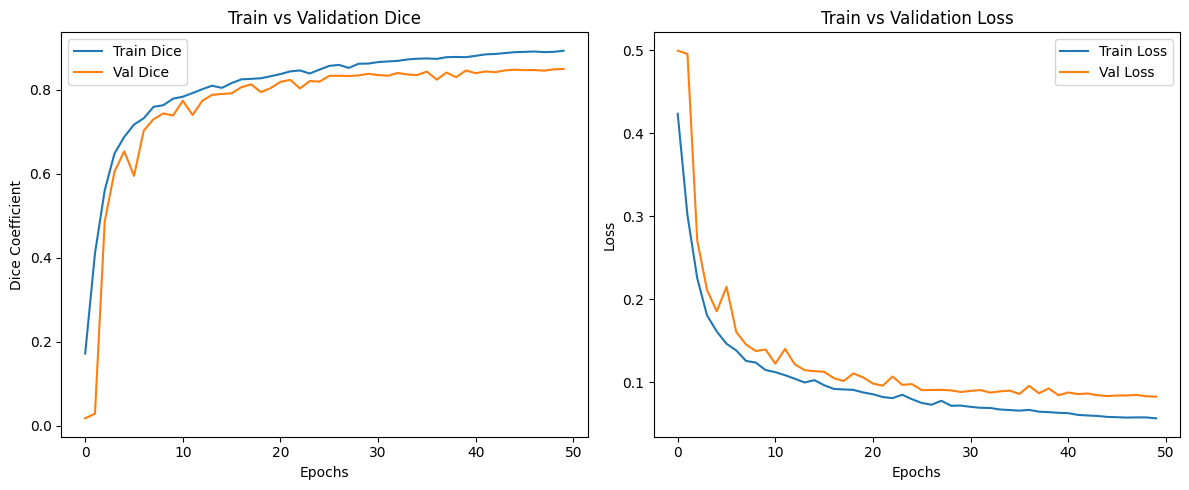

In [26]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate,
    BatchNormalization, Activation, Dense, Reshape
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from skimage.filters import threshold_otsu
from transformers import TFBertModel, BertTokenizer
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------
# 1. Data Loading (Images & Masks)
# -------------------------------
IMG_HEIGHT, IMG_WIDTH = 128, 128
IMG_CHANNELS = 1

def load_images(image_dir, mask_dir):
    images = []
    masks = []
    image_files = sorted(os.listdir(image_dir))
    for img_file in image_files:
        img_path = os.path.join(image_dir, img_file)
        mask_path = os.path.join(mask_dir, img_file)
        # Load image and mask
        img = load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode="grayscale")
        mask = load_img(mask_path, target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode="grayscale")
        # Convert image to array and normalize
        img_array = img_to_array(img) / 255.0
        # Convert mask to array and apply Otsu thresholding
        mask_array = img_to_array(mask).astype('uint8').squeeze()  # remove channel dimension
        thresh = threshold_otsu(mask_array)
        binary_mask = (mask_array > thresh).astype(np.float32)
        # Expand dims to get shape (H, W, 1)
        binary_mask = np.expand_dims(binary_mask, axis=-1)
        images.append(img_array)
        masks.append(binary_mask)
    return np.array(images), np.array(masks)

# Example directories for training and validation (update paths as needed)
train_frames_dir = "/kaggle/working/train/frames"
train_masks_dir  = "/kaggle/working/train/masks"
validation_frames_dir = "/kaggle/working/validation/frames"
validation_masks_dir  = "/kaggle/working/validation/masks"

X_train, y_train = load_images(train_frames_dir, train_masks_dir)
X_val, y_val = load_images(validation_frames_dir, validation_masks_dir)

# -------------------------------
# 2. Build the Multi-Modal Model
# -------------------------------

# Custom Keras layer to wrap TFBertModel.
class BertLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(BertLayer, self).__init__(**kwargs)
        # Load pretrained BERT model from Hugging Face (from_pt=True loads weights from PyTorch)
        self.bert = TFBertModel.from_pretrained("bert-base-uncased", from_pt=True)
    def call(self, inputs):
        # Ensure inputs are a tf.Tensor with type int32.
        inputs = tf.convert_to_tensor(inputs, dtype=tf.int32)
        # Get the model outputs; we use the pooled output (index 1).
        outputs = self.bert(inputs)
        return outputs[1]

# Image Encoder (U-Net style encoder)
def image_encoder(img_input):
    # Block 1
    c1 = Conv2D(64, 3, padding='same')(img_input)
    c1 = BatchNormalization()(c1)
    c1 = Activation('relu')(c1)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(64, 3, padding='same')(c1)
    c1 = BatchNormalization()(c1)
    c1 = Activation('relu')(c1)
    p1 = MaxPooling2D(2)(c1)
    
    # Block 2
    c2 = Conv2D(128, 3, padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Activation('relu')(c2)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(128, 3, padding='same')(c2)
    c2 = BatchNormalization()(c2)
    c2 = Activation('relu')(c2)
    p2 = MaxPooling2D(2)(c2)
    
    # Block 3
    c3 = Conv2D(256, 3, padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Activation('relu')(c3)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(256, 3, padding='same')(c3)
    c3 = BatchNormalization()(c3)
    c3 = Activation('relu')(c3)
    p3 = MaxPooling2D(2)(c3)
    
    # Block 4
    c4 = Conv2D(512, 3, padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Activation('relu')(c4)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(512, 3, padding='same')(c4)
    c4 = BatchNormalization()(c4)
    c4 = Activation('relu')(c4)
    p4 = MaxPooling2D(2)(c4)
    
    # Bottleneck
    c5 = Conv2D(1024, 3, padding='same')(p4)
    c5 = BatchNormalization()(c5)
    c5 = Activation('relu')(c5)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(1024, 3, padding='same')(c5)
    c5 = BatchNormalization()(c5)
    c5 = Activation('relu')(c5)
    
    return c1, c2, c3, c4, c5

# Text Encoder using our custom BertLayer
def text_encoder(text_input):
    bert_output = BertLayer()(text_input)
    text_features = Dense(128, activation='relu')(bert_output)
    return text_features

# Attention Gate for skip connections
def attention_gate(x, g, inter_channels):
    """
    x: encoder feature map (skip connection)
    g: gating signal from decoder
    inter_channels: number of intermediate channels (typically x's channels // 2)
    """
    theta_x = Conv2D(inter_channels, kernel_size=1, strides=1, padding='same')(x)
    phi_g = Conv2D(inter_channels, kernel_size=1, strides=1, padding='same')(g)
    add_xg = tf.keras.layers.add([theta_x, phi_g])
    act_xg = Activation('relu')(add_xg)
    psi = Conv2D(1, kernel_size=1, strides=1, padding='same')(act_xg)
    psi = Activation('sigmoid')(psi)
    out = tf.keras.layers.multiply([x, psi])
    return out

# Fusion Module: Tile text features and concatenate with image features
def fusion_module(image_features, text_features, target_shape):
    H, W = target_shape  # For example (8,8)
    fused_dim = 128       # Projection channels for text features
    text_proj = Dense(H * W * fused_dim, activation='relu')(text_features)
    text_reshaped = Reshape((H, W, fused_dim))(text_proj)
    fused = concatenate([image_features, text_reshaped], axis=-1)
    fused = Conv2D(1024, 3, padding='same', activation='relu')(fused)
    return fused

# Segmentation Decoder (U-Net style with skip connections and attention gates)
def segmentation_decoder(fused_features, c4, c3, c2, c1):
    u6 = UpSampling2D(2)(fused_features)
    # Apply attention gate on skip connection c4 with gating signal u6
    attn_c4 = attention_gate(c4, u6, inter_channels=256)
    u6 = concatenate([u6, attn_c4])
    c6 = Conv2D(512, 3, padding='same')(u6)
    c6 = BatchNormalization()(c6)
    c6 = Activation('relu')(c6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(512, 3, padding='same')(c6)
    c6 = BatchNormalization()(c6)
    c6 = Activation('relu')(c6)
    
    u7 = UpSampling2D(2)(c6)
    attn_c3 = attention_gate(c3, u7, inter_channels=128)
    u7 = concatenate([u7, attn_c3])
    c7 = Conv2D(256, 3, padding='same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Activation('relu')(c7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(256, 3, padding='same')(c7)
    c7 = BatchNormalization()(c7)
    c7 = Activation('relu')(c7)
    
    u8 = UpSampling2D(2)(c7)
    attn_c2 = attention_gate(c2, u8, inter_channels=64)
    u8 = concatenate([u8, attn_c2])
    c8 = Conv2D(128, 3, padding='same')(u8)
    c8 = BatchNormalization()(c8)
    c8 = Activation('relu')(c8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(128, 3, padding='same')(c8)
    c8 = BatchNormalization()(c8)
    c8 = Activation('relu')(c8)
    
    u9 = UpSampling2D(2)(c8)
    attn_c1 = attention_gate(c1, u9, inter_channels=32)
    u9 = concatenate([u9, attn_c1])
    c9 = Conv2D(64, 3, padding='same')(u9)
    c9 = BatchNormalization()(c9)
    c9 = Activation('relu')(c9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(64, 3, padding='same')(c9)
    c9 = BatchNormalization()(c9)
    c9 = Activation('relu')(c9)
    
    outputs = Conv2D(1, 1, activation='sigmoid')(c9)
    return outputs

# Build the complete multi-modal model
def build_multimodal_model(input_size=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), max_seq_length=32):
    # Image input
    img_input = Input(shape=input_size, name="image_input")
    # Text input (must be int32)
    text_input = Input(shape=(max_seq_length,), dtype=tf.int32, name="text_input")
    
    # Encode image and text
    c1, c2, c3, c4, c5 = image_encoder(img_input)
    text_features = text_encoder(text_input)
    
    # Fusion: assume c5 shape is (8, 8, 1024) for 128x128 input (4 poolings: 128/16=8)
    fused_features = fusion_module(c5, text_features, target_shape=(8, 8))
    
    outputs = segmentation_decoder(fused_features, c4, c3, c2, c1)
    
    model = Model(inputs=[img_input, text_input], outputs=outputs)
    return model

# Instantiate the model
model = build_multimodal_model()
model.summary()


from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
checkpoint = ModelCheckpoint("best_model.keras", monitor="val_loss", save_best_only=True, verbose=1)
callbacks = [lr_scheduler, early_stopping, checkpoint]

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss=combined_loss,
              metrics=[dice_coefficient, iou_coefficient])

# -------------------------------
# 4. Prepare Text Inputs for Training
# -------------------------------
max_seq_length = 32

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize_texts(texts, max_seq_length):
    encoding = tokenizer(texts, max_length=max_seq_length, padding='max_length', truncation=True, return_tensors="np")
    return encoding['input_ids'].astype(np.int32)

df_text = pd.read_excel("/kaggle/working/combined_text.xlsx", engine='openpyxl')
dummy_texts_train = ["this is a dummy caption"] * len(X_train)
dummy_texts_val = ["this is a dummy caption"] * len(X_val)

X_text_train = tokenize_texts(dummy_texts_train, max_seq_length)
X_text_val = tokenize_texts(dummy_texts_val, max_seq_length)

# -------------------------------
# 5. Train the Model
# -------------------------------
history = model.fit(
    [X_train, X_text_train], y_train,
    validation_data=([X_val, X_text_val], y_val),
    batch_size=16,
    epochs=50,
    callbacks=callbacks,
    verbose=1
)

# -------------------------------
# 6. Plot Training History
# -------------------------------
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history.get('dice_coefficient', history.history.get('accuracy')), label='Train Dice')
plt.plot(history.history.get('val_dice_coefficient', history.history.get('val_accuracy')), label='Val Dice')
plt.title('Train vs Validation Dice')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Train vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [27]:
import os
import numpy as np
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from skimage.filters import threshold_otsu
import pandas as pd
import matplotlib.pyplot as plt

# Assume that the multi-modal model (named 'model') and tokenizer have been defined and loaded.
# For example:
# model = build_multimodal_model()   # Your multi-modal model instance
# tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# -------------------------------
# Test dataset directories
# -------------------------------
test_frames_dir = "/kaggle/working/test/frames"
test_masks_dir = "/kaggle/working/test/masks"
test_text_dir = "/kaggle/working/combined_text.xlsx"  # Directory containing text files for test images

# -------------------------------
# Function to load and preprocess a test image and its corresponding mask
# -------------------------------
def load_test_image(file_name):
    img_path = os.path.join(test_frames_dir, file_name)
    mask_path = os.path.join(test_masks_dir, file_name)
    
    # Load image and mask (resize to 128x128, grayscale)
    img = load_img(img_path, target_size=(128, 128), color_mode='grayscale')
    mask = load_img(mask_path, target_size=(128, 128), color_mode='grayscale')
    
    # Convert image to array and normalize
    img_array = img_to_array(img) / 255.0
    
    # Convert mask to array and apply Otsu's thresholding
    mask_array = img_to_array(mask).astype('uint8').squeeze()  # Remove channel dimension
    thresh = threshold_otsu(mask_array)
    binary_mask = (mask_array > thresh).astype(np.uint8)
    
    return img_array, binary_mask

# -------------------------------
# Function to load corresponding text data for a test image
# -------------------------------
def load_test_text(file_name):
    # Assume text file has the same base name with a .txt extension.
    base_name = os.path.splitext(file_name)[0]
    text_path = os.path.join(test_text_dir, base_name + ".xlsx")
    if os.path.exists(text_path):
        with open(text_path, "r") as f:
            text = f.read().strip()
    else:
        text = "this is a dummy caption"  # Fallback dummy text if file not found.
    return text

# -------------------------------
# Function to tokenize a single text input
# -------------------------------
def tokenize_text(text, max_seq_length=32):
    encoding = tokenizer(text, max_length=max_seq_length, padding='max_length',
                         truncation=True, return_tensors="np")
    # Return a 1D array (token IDs)
    return encoding['input_ids'].astype(np.int32)[0]

# -------------------------------
# Function to predict mask using both image and text data
# -------------------------------
def predict_mask(model, img_array, text_token):
    # Expand dims to add batch dimension for both image and text input.
    img_array_expanded = np.expand_dims(img_array, axis=0)
    text_array_expanded = np.expand_dims(text_token, axis=0)
    # Predict using the multi-modal model (expects [image, text] inputs)
    predicted_mask = model.predict([img_array_expanded, text_array_expanded], verbose=0)
    # Remove batch dimension and channel dimension (assuming output shape is [1, H, W, 1])
    predicted_mask = predicted_mask[0, :, :, 0]
    # Apply threshold to obtain binary mask
    predicted_mask = (predicted_mask > 0.5).astype(np.uint8)
    return predicted_mask

# -------------------------------
# Initialize lists to store metric values
# -------------------------------
dice_scores = []
iou_scores = []
accuracies = []
precisions = []
recalls = []

# -------------------------------
# List of test image files
# -------------------------------
test_image_files = os.listdir(test_frames_dir)

# -------------------------------
# Iterate over the test set
# -------------------------------
for file_name in tqdm(test_image_files, desc="Evaluating on test set"):
    # Load image and ground truth mask
    img_array, ground_truth_mask = load_test_image(file_name)
    ground_truth_mask = ground_truth_mask.flatten()  # Flatten to 1D
    
    # Load and tokenize corresponding text data
    text = load_test_text(file_name)
    text_token = tokenize_text(text, max_seq_length=32)
    
    # Predict mask using both image and text
    predicted_mask = predict_mask(model, img_array, text_token)
    predicted_mask = predicted_mask.flatten()
    
    # Calculate True Positives (TP), False Positives (FP), False Negatives (FN), True Negatives (TN)
    TP = np.sum((ground_truth_mask == 1) & (predicted_mask == 1))
    FP = np.sum((ground_truth_mask == 0) & (predicted_mask == 1))
    FN = np.sum((ground_truth_mask == 1) & (predicted_mask == 0))
    TN = np.sum((ground_truth_mask == 0) & (predicted_mask == 0))
    
    # Calculate metrics
    dice_score = (2 * TP) / (2 * TP + FP + FN) if (2 * TP + FP + FN) > 0 else 0
    iou_score = TP / (TP + FP + FN) if (TP + FP + FN) > 0 else 0
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    
    # Append metrics
    dice_scores.append(dice_score)
    iou_scores.append(iou_score)
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)

# -------------------------------
# Compute average metrics
# -------------------------------
avg_dice = np.mean(dice_scores)
avg_iou = np.mean(iou_scores)
avg_accuracy = np.mean(accuracies)
avg_precision = np.mean(precisions)
avg_recall = np.mean(recalls)

# -------------------------------
# Print the results
# -------------------------------
print("\nQuantitative Evaluation on Test Set:")
print(f"Average Dice Coefficient: {avg_dice:.4f}")
print(f"Average IoU Score: {avg_iou:.4f}")
print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")


Evaluating on test set: 100%|██████████| 273/273 [00:29<00:00,  9.12it/s]


Quantitative Evaluation on Test Set:
Average Dice Coefficient: 0.7408
Average IoU Score: 0.6384
Average Accuracy: 0.9958
Average Precision: 0.8024
Average Recall: 0.7128
